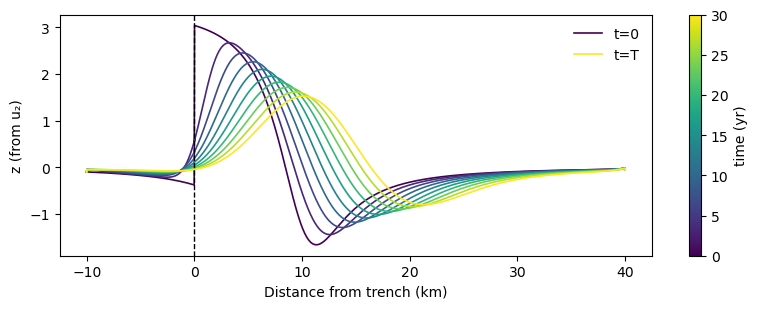

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

delta_deg = 20.0
delta = np.deg2rad(delta_deg)
x_d = 10.0
L = x_d / np.cos(delta)
d = L * np.sin(delta)
s = -10.0
x = np.linspace(-10.0, 40.0, 3001)  # km

def displacements_373(x1, s, delta, d, x_d):
    zeta = (x1 - x_d) / d
    arcterm = np.arctan(zeta) - 0.5 * np.pi * np.sign(x1)
    u1 = -(s / np.pi) * ( np.cos(delta) * arcterm + (np.sin(delta) - zeta*np.cos(delta)) / (1.0 + zeta**2) )
    u2 =  (s / np.pi) * ( np.sin(delta) * arcterm + (np.cos(delta) + zeta*np.sin(delta)) / (1.0 + zeta**2) )
    return u1, u2

u1, u2 = displacements_373(x, s, delta, d, x_d)
z0 = u2.copy()

Pe_target = 1.0      # desired Peclet: Pe = |C| * h_ref_km / D
h_ref_km  = 1.0      # reference length for Pe
eta_wiggle = 0.2     # artificial viscosity coefficient (0.0–1.0), optional

gamma, lam_s, S0, hface, H0 = 9810.0, 0.35, 0.01, 1.0, 0.20
kd, M, A, B = 5.0e-8, 1.0, 1.0, 0.2
pref = hface * kd * gamma / (1.0 - lam_s)          # [m/s]
C_mag = abs((pref * S0 * M * A) * (365.0*24*3600.0) / 1000.0)  # [km/yr], magnitude only

def stepper_CN_snapshots(C, D, x, z0, dt, nt, snap_steps, fixed_dirichlet=True):
    dx = x[1]-x[0]
    alpha = D * dt / (2.0 * dx**2)
    beta  = C * dt / (4.0 * dx)
    Nx = x.size
    Nint = Nx-2
    mainA = (1.0 + 2.0*alpha) * np.ones(Nint)
    offmA = ( beta - alpha) * np.ones(Nint-1)
    offpA = (-beta - alpha) * np.ones(Nint-1)
    mainB = (1.0 - 2.0*alpha) * np.ones(Nint)
    offmB = (-beta + alpha) * np.ones(Nint-1)
    offpB = ( beta + alpha) * np.ones(Nint-1)
    def solve_tridiag(a_sub, a_main, a_sup, rhs):
        n = len(a_main)
        c, d, b = a_sup.copy(), a_main.copy(), a_sub.copy()
        for i in range(1, n):
            w = b[i-1]/d[i-1]
            d[i]   -= w*c[i-1]
            rhs[i] -= w*rhs[i-1]
        xsol = np.empty(n)
        xsol[-1] = rhs[-1]/d[-1]
        for i in range(n-2, -1, -1):
            xsol[i] = (rhs[i] - c[i]*xsol[i+1])/d[i]
        return xsol
    z = z0.copy()
    snaps = {0: z.copy()}
    if fixed_dirichlet:
        zL, zR = z0[0], z0[-1]
    for k in range(1, nt+1):
        zin = z[1:-1]
        rhs = mainB*zin
        rhs[1:]  += offmB * zin[:-1]
        rhs[:-1] += offpB * zin[1:]
        if fixed_dirichlet:
            rhs[0]   += (alpha - beta) * zL
            rhs[-1]  += (alpha + beta) * zR
        z_int = solve_tridiag(offmA, mainA, offpA, rhs)
        if fixed_dirichlet:
            z[0], z[-1] = zL, zR
        z[1:-1] = z_int
        if k in snap_steps:
            snaps[k] = z.copy()
    return snaps

dx = x[1]-x[0]
D_base = (C_mag * h_ref_km) / max(Pe_target, 1e-6)
D = D_base + eta_wiggle * C_mag * dx * 0.5

def stepper_CN(C, D, x, z0, dt, nt):
    snaps = stepper_CN_snapshots(C,D,x,z0,dt,nt,set(),fixed_dirichlet=True)
    return snaps.get(nt, z0)

dt_probe, nt_probe = 0.05, 100
z_try_pos = stepper_CN(+C_mag, D, x, z0, dt_probe, nt_probe)
g0 = np.gradient(z0, x);  i0 = int(np.argmin(g0))
g1 = np.gradient(z_try_pos, x); i1 = int(np.argmin(g1))
dx_probe = x[i1] - x[i0]
C = +C_mag if dx_probe > 0 else -C_mag

dt, nt = 0.05, 600  # 30 years total
snap_steps = np.unique(np.linspace(0, nt, 10, dtype=int))  # 10 snapshots including 0 and nt
snaps = stepper_CN_snapshots(C, D, x, z0, dt, nt, set(snap_steps), fixed_dirichlet=True)

T = dt*nt
Pe_actual = (abs(C) * h_ref_km) / D if D>0 else np.inf
norm = Normalize(vmin=0.0, vmax=T)
cmap = plt.get_cmap("viridis")   # pick any colormap
sm = ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

fig, ax = plt.subplots(figsize=(8.2, 3.2))
for k in snap_steps:
    t_k = k*dt
    color = cmap(norm(t_k))
    label = "t=0" if k==0 else ("t=T" if k==nt else None)
    ax.plot(x, snaps[k], lw=1.2, label=label, color=color)

ax.axvline(0.0, ls="--", lw=1.0, color="k")
ax.set_xlabel("Distance from trench (km)")
ax.set_ylabel("z (from u₂)")

cb = fig.colorbar(sm, ax=ax)
cb.set_label("time (yr)")

ax.legend(frameon=False, loc="upper right")
plt.tight_layout()
plt.show()